<a href="https://colab.research.google.com/github/Matvezy/Body-Mesurments/blob/master/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [93]:
%cd /content/gdrive/MyDrive/AITrainingLibRandClothHair500

/content/gdrive/MyDrive/AITrainingLibRandClothHair500


In [94]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random

# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person'
]

def get_prediction(img_path, threshold):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
        ie: eg. segment of cat is made 1 and rest of the image is made 0
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class


def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  """
  instance_segmentation_api
    parameters:
      - img_path - path to input image
    method:
      - prediction is obtained by get_prediction
      - each mask is given random color
      - each mask is added to the image in the ration 1:0.8 with opencv
      - final output is displayed
  """
  masks, boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()


In [95]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [98]:
class Transforms():
    def __init__(self):
        pass

    def crop_person(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])
        Ry = height/1024
        Rx = width/1024
        #img_shape = image.shape
        landmarks = torch.tensor(landmarks) * torch.tensor([[Rx, Ry]])
        #landmarks = landmarks / torch.tensor([img_shape[2], img_shape[1]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image, landmarks = self.crop_person(image, landmarks, crops)
        return image, landmarks

In [99]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('trainFront.xml')
        root = tree.getroot()
        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        for filename in root[1]:
            self.image_filenames.append(filename.attrib['file'])
            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(25):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)
        print(self.crops)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = torch.load(self.image_filenames[index])
        landmarks = self.landmarks[index]
        """
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])
        """
        #landmarks = landmarks - 0.5

        return image, landmarks

In [100]:
dataset = FaceLandmarksDataset()

[{'top': '246', 'left': '236', 'width': '461', 'height': '636'}, {'top': '166', 'left': '264', 'width': '456', 'height': '752'}, {'top': '141', 'left': '193', 'width': '616', 'height': '783'}, {'top': '68', 'left': '279', 'width': '553', 'height': '858'}, {'top': '154', 'left': '218', 'width': '559', 'height': '785'}, {'top': '84', 'left': '185', 'width': '591', 'height': '823'}, {'top': '193', 'left': '285', 'width': '474', 'height': '786'}, {'top': '30', 'left': '246', 'width': '553', 'height': '887'}, {'top': '199', 'left': '252', 'width': '458', 'height': '708'}, {'top': '190', 'left': '294', 'width': '477', 'height': '702'}, {'top': '137', 'left': '282', 'width': '497', 'height': '772'}, {'top': '168', 'left': '265', 'width': '470', 'height': '757'}, {'top': '261', 'left': '268', 'width': '466', 'height': '644'}, {'top': '50', 'left': '300', 'width': '585', 'height': '845'}, {'top': '139', 'left': '251', 'width': '504', 'height': '837'}, {'top': '191', 'left': '247', 'width': '585

['AITrainingLib/1/mask.pt', 'AITrainingLib/2/mask.pt', 'AITrainingLib/4/mask.pt', 'AITrainingLib/5/mask.pt', 'AITrainingLib/6/mask.pt', 'AITrainingLib/10/mask.pt', 'AITrainingLib/11/mask.pt', 'AITrainingLib/12/mask.pt', 'AITrainingLib/13/mask.pt', 'AITrainingLib/14/mask.pt', 'AITrainingLib/15/mask.pt', 'AITrainingLib/16/mask.pt', 'AITrainingLib/17/mask.pt', 'AITrainingLib/18/mask.pt', 'AITrainingLib/19/mask.pt', 'AITrainingLib/20/mask.pt', 'AITrainingLib/21/mask.pt', 'AITrainingLib/22/mask.pt', 'AITrainingLib/23/mask.pt', 'AITrainingLib/24/mask.pt', 'AITrainingLib/25/mask.pt', 'AITrainingLib/26/mask.pt', 'AITrainingLib/27/mask.pt', 'AITrainingLib/28/mask.pt', 'AITrainingLib/29/mask.pt', 'AITrainingLib/30/mask.pt', 'AITrainingLib/31/mask.pt', 'AITrainingLib/32/mask.pt', 'AITrainingLib/33/mask.pt', 'AITrainingLib/34/mask.pt', 'AITrainingLib/35/mask.pt', 'AITrainingLib/36/mask.pt', 'AITrainingLib/37/mask.pt', 'AITrainingLib/39/mask.pt', 'AITrainingLib/40/mask.pt', 'AITrainingLib/41/mask.p

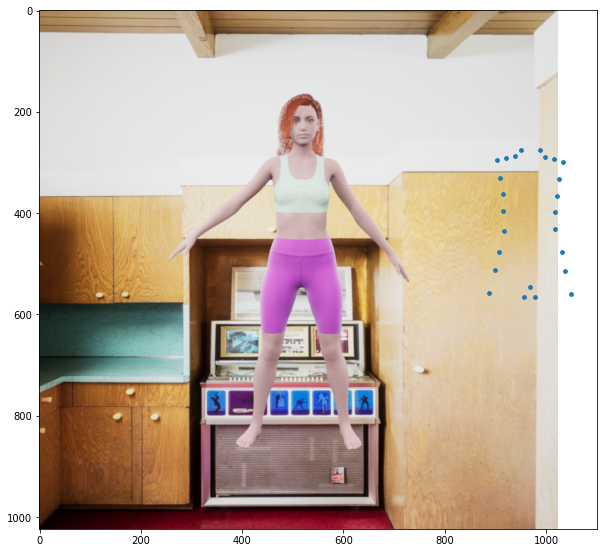

In [102]:
print(dataset.image_filenames)
image, landmarks = dataset[1]
image = image.type(torch.float32).numpy()[0]
image = Image.open('AITrainingLib/2/Front.png')
print(landmarks)
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=14);

In [28]:
print(image[0][238])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [32]:
img = Image.open('/content/gdrive/MyDrive/AITrainingLibRandClothHair500/AITrainingLib/1/Side.png')
transform = T.Compose([T.ToTensor()])
img = transform(img)
if img.size()[0] == 4:
  img = img[:3, ...] 
pred = model([img])
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu()
masks = masks.type(torch.float32).numpy()
labels = pred[0]['labels'].detach().numpy()
scores = pred[0]['scores'].detach().numpy()
indh = np.where(labels == 1)
needed = np.where(scores[indh] > 0.8)
mask = masks[needed][0]
boxes = pred[0]['boxes'].detach().numpy()
box = boxes[needed].astype('int')[0]
mask = mask[box[1]:box[3], box[0]:box[2]]

<class 'numpy.ndarray'>


In [35]:
print(mask[238])

[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


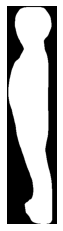

In [34]:
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.savefig("/content/gdrive/MyDrive/test.png", bbox_inches='tight',pad_inches = 0)

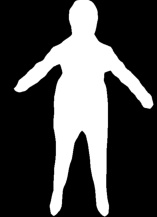

In [60]:
img = Image.open('/content/gdrive/MyDrive/test.png')
img